## Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten

## Data Preparations

### 1. Load data files

In [2]:
# load the data from keras datasets
fashion_mnist = tf.keras.datasets.fashion_mnist
# divide the data into train and test
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data() 

### 1.1 Describe the data

In [3]:
# shape of train data
print('The train data has', X_train.shape[0], 'examples with shape', X_train.shape[1:])

The train data has 60000 examples with shape (28, 28)


In [4]:
# shape of test data
print('The test data has', X_test.shape[0], 'examples with shape', X_test.shape[1:])

The test data has 10000 examples with shape (28, 28)


In [5]:
classes_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
unique_labels = np.unique(y_train)
labels_dict = {classes_names[i]: unique_labels[i] for i in range(len(unique_labels))}
for class_name, label in labels_dict.items():
    print('The label', label, 'represents a class that is', class_name)

The label 0 represents a class that is T-shirt/top
The label 1 represents a class that is Trouser
The label 2 represents a class that is Pullover
The label 3 represents a class that is Dress
The label 4 represents a class that is Coat
The label 5 represents a class that is Sandal
The label 6 represents a class that is Shirt
The label 7 represents a class that is Sneaker
The label 8 represents a class that is Bag
The label 9 represents a class that is Ankle boot


### 1.5 Draw some of the images

Some of the images from fashion-MNIST:


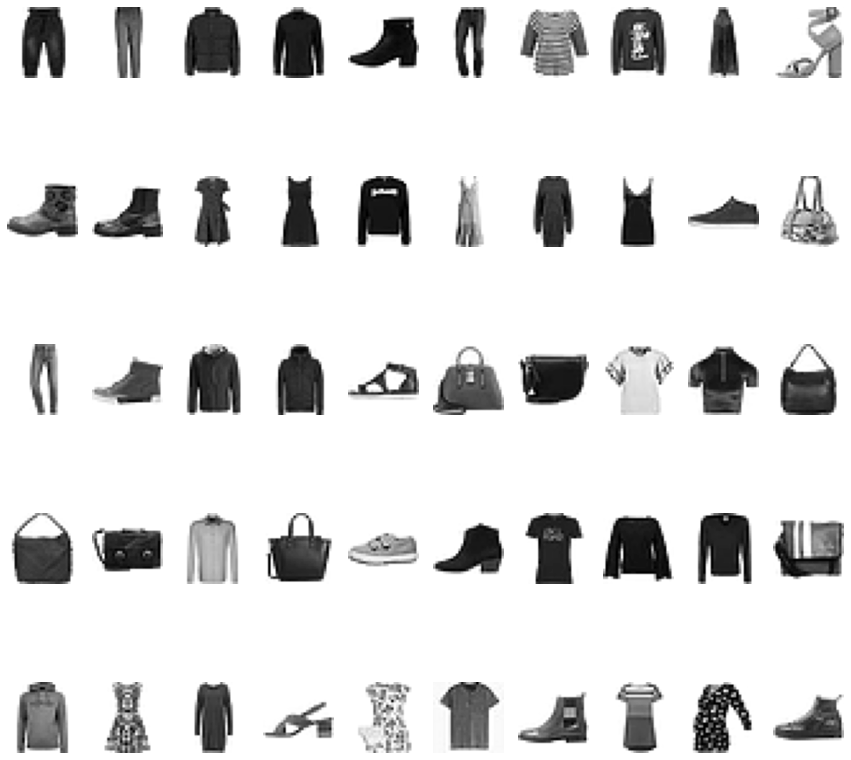

In [6]:
def draw_images(data, num_of_images):
    '''
    This function draws a random images from the data, by specifying how many images to draw
    '''
    random_indexes = [np.random.randint(0, len(X_train)) for i in range(num_of_images)]
    fig , axis = plt.subplots(5,10)
    fig.set_figwidth(15)
    fig.set_figheight(15)
    i , j = 0 , 0
    for idx in random_indexes:
        image = X_train[idx]
        axis[i,j].imshow(image, cmap='binary')
        axis[i,j].axis('off')
        j += 1
        if j % 10 == 0:
            i += 1
            j = 0
# draw some images
print('Some of the images from fashion-MNIST:')
draw_images(data=X_train, num_of_images=50)

### 2. Carry out required preprocessing operations on the data

In [7]:
# normalize train and test data
X_train = X_train / 255.0
X_test = X_test / 255.0

### 3. Encode the labels

In [8]:
# encode train and test labels
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

## Training a CNN neural network

### LeNet-5 Architecture

In [11]:
def lenet_5():
    '''
    This function defines the architecure of LeNet-5
    '''
    model = Sequential([
        Input(shape=(28,28,1)),
        Conv2D(filters= 6, kernel_size=(5,5), strides=(1,1), padding='valid'),
        AveragePooling2D(pool_size = (2,2), strides = 2),
        Conv2D(filters= 16, kernel_size=(5,5), strides=(1,1), padding='valid'),
        AveragePooling2D(pool_size = (2,2), strides = 2),
        Flatten(),
        Dense(units = 120, activation='relu'),
        Dense(units = 84, activation='relu'),
        Dense(units= 10, activation='softmax')
    ])
    
    return model

In [12]:
# initialize the model and output the model summary
model = lenet_5()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
average_pooling2d_2 (Average (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
average_pooling2d_3 (Average (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 120)               30840     
_________________________________________________________________
dense_4 (Dense)              (None, 84)               